In [15]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics, datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
import skimage.transform as T

sizes = ["224", "300", "512"]

PATH = "/home/will/Documents/datasets/wild_animals"

In [18]:
def load_image_files(data_dir, lim_sample=None):
    image_dir = Path(data_dir)
    folders = [d for d in image_dir.iterdir() if d.is_dir()]

    x, y = [], []
    for class_idx, direc in enumerate(folders):
        for i, file in enumerate(direc.iterdir()):
            if lim_sample and i >= lim_sample:
                break
            img = imread(file)
            img = T.resize(img, (64, 64, 3))
            x.append(img.flatten()) 
            y.append(class_idx)

    x = np.array(x, dtype=list)
    y = np.array(y, dtype=list).astype(int)

    return x, y 

x, y = load_image_files(PATH + "/" + sizes[0])

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=1234)
first_x = x_train[:int(len(x_train)*0.4)]
first_y = y_train[:int(len(y_train)*0.4)]
second_x = x_train[int(len(x_train)*0.4):]
second_y = y_train[int(len(y_train)*0.4):]

In [19]:
hyperparams = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['sigmoid']},
  {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
]

svc = svm.SVC(probability=True)
grid = GridSearchCV(svc, hyperparams)
grid.fit(first_x, first_y)

GridSearchCV(estimator=SVC(probability=True),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['poly']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['sigmoid']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}])

In [20]:
from sklearn.metrics import roc_curve, auc, accuracy_score

pred = grid.predict(x_test)
accuracy = round(accuracy_score(pred, y_test) * 100, 3)
print(f"The model is {accuracy}% accurate")

print(grid.best_estimator_)
print(grid.best_params_)

The model is 35.362% accurate
SVC(C=10, gamma=0.001, probability=True)
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [21]:
best_svc = grid.best_estimator_
best_svc.fit(second_x, second_y)

SVC(C=10, gamma=0.001, probability=True)

Text(0.5, 0, 'FP Rate')

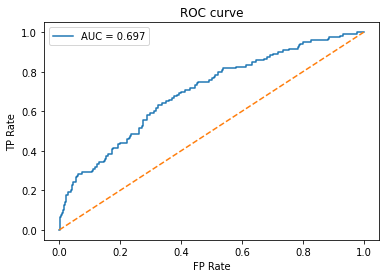

In [22]:
probs = best_svc.predict_proba(x_test)
y_prob = probs[:, 1]

fp, tp, thresholds = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = round(auc(fp, tp), 3)

plt.title("ROC curve")
roc_plot = plt.plot(fp, tp, label=f"AUC = {roc_auc}")

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls="--")
plt.ylabel("TP Rate")
plt.xlabel("FP Rate")